In [2]:
import sleap 
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np

In [3]:
data_folder = Path("/Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data")
prism_labels = sleap.io.dataset.load_file(str(data_folder/"best_side.slp"))
ventral_labels = sleap.io.dataset.load_file(str(data_folder/"best_ventral.slp"))

In [4]:
import pickle

step_data_stance_swing_path = Path("/Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/revision_new_step_PR_bestdata_fly001_trial001subset_video_4_start5751_end6001_stepping.txt")
video_start_frame = 5751
video_end_frame = 6001

start, end = None, None
swing_stance_dict = {}
with open(step_data_stance_swing_path, "r") as f:
    for line in f.readlines():
        line = line.strip()
        if line.startswith("Start"):
            start = int(line.split(" ")[1])
        if line.startswith("End"):
            end = int(line.split(" ")[1])
        if line in ["RF", "RM", "RH", "LF", "LM", "LH"]:
            assert start is not None and end is not None, "Start and end not defined"
            leg = line
            swing_stance_dict[leg] = {}
        if "swing" in line or "stance" in line:
            phase = line.split(" ")[0]
            indexes = np.array(line.split(" ")[1:]).astype(int)
            assert np.all(indexes >= start-1) and np.all(indexes <= end+1), "Indexes not in range"
            indexes -= start
            if phase == "swing":
                # the frames in the file are the ones were the first elevation 
                #is observed but really the swing starts inbeetween the two frames
                # This gives some margin for the adhesion
                indexes -= 1
            # save as integers
            swing_stance_dict[leg][phase] = indexes
        else:
            continue

# put in video indexes
for leg, phases in swing_stance_dict.items():
    for phase, indexes in phases.items():
        swing_stance_dict[leg][phase] = indexes + start - video_start_frame


with open("/Users/stimpfli/Desktop/flygym_other/flygym/data/behavior/single_steps_untethered.pkl", "rb") as f:
    single_steps_data = pickle.load(f)

single_steps_name = single_steps_data["meta"]["name"]

In [5]:
frontleg, frontleg_id, midleg, midleg_id, hindleg, hindleg_id = single_steps_data["meta"]["name"].split("_")
leg_step_ids = {}
for leg, id in zip([frontleg, midleg, hindleg], [frontleg_id, midleg_id, hindleg_id]):
    index = int(id[0])
    state = id[1:]
    leg_step_ids[leg] = [swing_stance_dict[leg][state][index], swing_stance_dict[leg][state][index+1]]
leg_step_ids

{'RF': [35, 51], 'RM': [39, 56], 'LH': [41, 57]}

In [6]:
for node in ["V-F-Claw", "V-M-Claw", "V-H-Claw"]:
    prism_labels.skeleton.delete_node(node)

In [7]:
s_skeletons = {}
v_skeletons = {}
for leg in leg_step_ids:
    sleg_skel = sleap.skeleton.Skeleton()
    leg_id = leg[1]+"-"
    for node in prism_labels.skeleton.nodes:
        if leg_id in node.name:
            sleg_skel.add_node(node.name)
    
    for edge in prism_labels.skeleton.edges:
        if leg_id in edge[0].name and leg_id in edge[1].name:
            sleg_skel.add_edge(edge[0].name, edge[1].name)
    
    s_skeletons[leg] = sleg_skel

    vleg_skel = sleap.skeleton.Skeleton()
    for node in ventral_labels.skeleton.nodes:
        if leg in node.name:
            vleg_skel.add_node(node.name)
    
    for edge in ventral_labels.skeleton.edges:
        if leg in edge[0].name and leg in edge[1].name:
            vleg_skel.add_edge(edge[0].name, edge[1].name)
    
    v_skeletons[leg] = vleg_skel

In [8]:
v_skeletons

{'RF': Skeleton(name='Skeleton-4', description='None', nodes=['RF-ThC', 'RF-CTr', 'RF-FTi', 'RF-TiTa', 'RF-Claw'], edges=[('RF-ThC', 'RF-CTr'), ('RF-CTr', 'RF-FTi'), ('RF-FTi', 'RF-TiTa'), ('RF-TiTa', 'RF-Claw')], symmetries=[]),
 'RM': Skeleton(name='Skeleton-6', description='None', nodes=['RM-ThC', 'RM-CTr', 'RM-FTi', 'RM-TiTa', 'RM-Claw'], edges=[('RM-ThC', 'RM-CTr'), ('RM-CTr', 'RM-FTi'), ('RM-FTi', 'RM-TiTa'), ('RM-TiTa', 'RM-Claw')], symmetries=[]),
 'LH': Skeleton(name='Skeleton-8', description='None', nodes=['LH-ThC', 'LH-CTr', 'LH-FTi', 'LH-TiTa', 'LH-Claw'], edges=[('LH-ThC', 'LH-CTr'), ('LH-CTr', 'LH-FTi'), ('LH-FTi', 'LH-TiTa'), ('LH-TiTa', 'LH-Claw')], symmetries=[])}

In [9]:
ventral_labels.skeleton.nodes

[Node(name='He', weight=1.0),
 Node(name='Th', weight=1.0),
 Node(name='Abd', weight=1.0),
 Node(name='LF-ThC', weight=1.0),
 Node(name='LF-CTr', weight=1.0),
 Node(name='LF-FTi', weight=1.0),
 Node(name='LF-TiTa', weight=1.0),
 Node(name='LF-Claw', weight=1.0),
 Node(name='LM-ThC', weight=1.0),
 Node(name='LM-CTr', weight=1.0),
 Node(name='LM-FTi', weight=1.0),
 Node(name='LM-TiTa', weight=1.0),
 Node(name='LM-Claw', weight=1.0),
 Node(name='LH-ThC', weight=1.0),
 Node(name='LH-CTr', weight=1.0),
 Node(name='LH-FTi', weight=1.0),
 Node(name='LH-TiTa', weight=1.0),
 Node(name='LH-Claw', weight=1.0),
 Node(name='RH-ThC', weight=1.0),
 Node(name='RH-CTr', weight=1.0),
 Node(name='RH-FTi', weight=1.0),
 Node(name='RH-TiTa', weight=1.0),
 Node(name='RH-Claw', weight=1.0),
 Node(name='RM-ThC', weight=1.0),
 Node(name='RM-CTr', weight=1.0),
 Node(name='RM-FTi', weight=1.0),
 Node(name='RM-TiTa', weight=1.0),
 Node(name='RM-Claw', weight=1.0),
 Node(name='RF-ThC', weight=1.0),
 Node(name='RF-

In [10]:
frame_out_path = data_folder / "labelled_frames"
frame_out_path.mkdir(parents=True, exist_ok=True)

# remove all images from the folder
for file in os.listdir(frame_out_path):
    os.remove(os.path.join(frame_out_path, file))

In [11]:
color = plt.cm.tab20.colors[1]
leg_color = plt.cm.tab20.colors[6]

# right on the top
vid_len, height, width , _ = prism_labels.video.shape
half_height = height // 2
reduction_factor = 100
figure_size = (np.round(height/reduction_factor).astype(int), np.round(width/reduction_factor).astype(int))

lw, ms = 3.0, 10.0

frames_with_instance = []

for i, (frame_side, frame_ventral) in enumerate(zip(prism_labels.labeled_frames, ventral_labels.labeled_frames)):
    assert np.all(frame_side.image == frame_ventral.image), "Frame are not matching"

    image = frame_side.image
    # instances might be empty
    plt.figure(figsize=(40, 20), dpi=100)
    plt.imshow(image, cmap="gray", origin='upper')
    if frame_side.user_instances and frame_ventral.user_instances:
        for instance in frame_side.user_instances:
            sleap.nn.viz.plot_instance(instance, cmap=[color], lw=lw, ms=ms)
            for leg, skel in s_skeletons.items():
                if i > leg_step_ids[leg][0] and i < leg_step_ids[leg][1]:
                    if leg[0] == "L":
                        if np.all(instance.numpy()[:, 1] < half_height):
                            sleap.nn.viz.plot_instance(instance, skeleton=skel, cmap=[leg_color], lw=lw, ms=ms)
                    elif leg[0] == "R":
                        if np.all(instance.numpy()[:, 1] > half_height):
                            sleap.nn.viz.plot_instance(instance, skeleton=skel, cmap=[leg_color], lw=lw, ms=ms)
        
        for instance in frame_ventral.user_instances:
            sleap.nn.viz.plot_instance(instance, cmap=[color], lw=lw, ms=ms)
            for leg, skel in v_skeletons.items():
                if i > leg_step_ids[leg][0] and i < leg_step_ids[leg][1]:
                    sleap.nn.viz.plot_instance(instance, skeleton=skel, cmap=[leg_color], lw=lw, ms=ms)
        
        frames_with_instance.append(i)
    
    # save the image without margins
    plt.ylim(55, height-55)
    plt.xlim(451, width-450)

    plt.gca().invert_yaxis()

    plt.axis("off")
    plt.tight_layout()
    plt.savefig(frame_out_path / f"frame_{i}.png", bbox_inches="tight", pad_inches=0)
    plt.close()

In [13]:
import cv2

# now read each of those images and stack the right 3d pose next to it
pose3d_path = Path("/Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/seqikpy_output/aligned_pose/")
pose3d_path = Path("/Users/stimpfli/Desktop/nmf2-paper/revision_stepping/data/seqikpy_output/ik_fk_comparison/")
pose3d_images_paths = list(pose3d_path.glob("azim_90_elev_90_*.png"))


pose_frame = cv2.imread(str(pose3d_images_paths[0]))
pose_height, pose_width = pose_frame.shape[:2]
frame_height, frame_width = cv2.imread(str(frame_out_path / "frame_0.png")).shape[:2]

# same height as pose3d
legend_image = cv2.imread(str(pose3d_path / "legend.png"))
pose3d_height, pose3d_width = cv2.imread(str(pose3d_images_paths[0])).shape[:2]
legend_image_height, legend_image_width = legend_image.shape[:2]

n_pose3d_views = 2
resize_factor = frame_height/(pose3d_height*n_pose3d_views + legend_image_height)
resized_width = int(pose3d_width*resize_factor) 
# make even number of pixels 
resized_width = resized_width + resized_width % 2
print(resized_width, pose3d_width*resize_factor)

output_path_pose = data_folder / "labelled_frames_w3dpose"
output_path_pose.mkdir(parents=True, exist_ok=True)

conversion_factor = len(frames_with_instance)/len(pose3d_images_paths)

for i in range(vid_len):
    base_frame = cv2.imread(str(frame_out_path / f"frame_{i}.png"))
    if i in frames_with_instance:
        pose3d_index = np.round((i-frames_with_instance[0])/conversion_factor).astype(int)
        pose3d_frame_side = cv2.imread(str(pose3d_path / f"azim_90_elev_0_{pose3d_index}.png"))
        pose3d_frame_ventral = cv2.imread(str(pose3d_path / f"azim_90_elev_-90_{pose3d_index}.png"))

        pose3d_frame = np.concatenate([legend_image_res, pose3d_frame_ventral, pose3d_frame_side], axis=0)
        pose3d_frame_res = cv2.resize(pose3d_frame, fx=resize_factor, fy=resize_factor, dsize=(resized_width, frame_height))

        # #pose3d_frame_profile = cv2.imread(str(pose3d_path / f"azim_30_elev_10_{pose3d_index}.png"))
        # pose3d_frame_side_res = cv2.resize(pose3d_frame_side, fx=resize_factor, fy=resize_factor, dsize=(resized_width, frame_height//n_pose3d_views))
        # pose3d_frame_ventral_res = cv2.resize(pose3d_frame_ventral, fx=resize_factor, fy=resize_factor, dsize=(resized_width, frame_height//n_pose3d_views))
        # #pose3d_frame_profile_res = cv2.resize(pose3d_frame_profile, fx=resize_factor, fy=resize_factor, dsize=(resized_width, frame_height//n_pose3d_views+1))
        # pose3d_frame = np.concatenate([pose3d_frame_ventral_res, pose3d_frame_side_res], axis=0)
    else:
        pose3d_frame = np.zeros((frame_height, resized_width, 3), dtype=np.uint8)
    
    combined = np.concatenate([pose3d_frame_res, base_frame], axis=1)
    cv2.imwrite(str(output_path_pose / f"frame_{i}.png"), combined)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type
>  - Can't parse 'dsize'. Sequence item with index 0 has a wrong type


In [15]:
legend_image_width*legend_img_fy, legend_image_height*legend_img_fy

(1970.0000000000002, 1970.0000000000002)

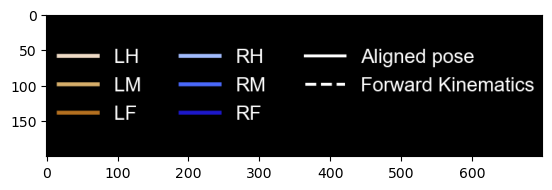

In [21]:
legend_image = cv2.imread(str(pose3d_path / "legend.png"))
plt.imshow(legend_image)

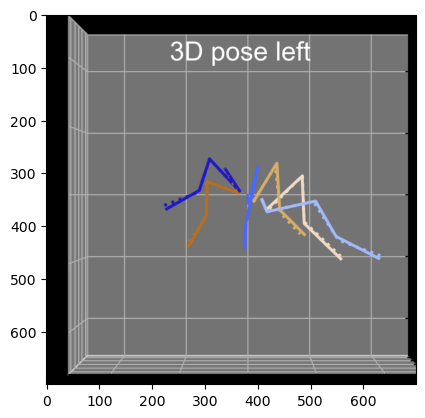

In [22]:
plt.imshow(cv2.imread(str(pose3d_path / f"azim_90_elev_0_0.png")))

In [ ]:
# make video out of the images using ffmpeg
video_out_path = data_folder / "labelled_frames_annotated.mp4"
# 12 fps = 10x reduction
# frame numbering is 1-indexed

os.system(f"ffmpeg -y -r 12 -f image2 -s {figure_size[1]}x{figure_size[0]} -i {frame_out_path / 'frame_%d.png'} -vcodec libx264 -crf 25 -pix_fmt yuv420p {video_out_path}")

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1671040356584/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1671040356584/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-gpl --ena

0

In [ ]:
# make video out of the images using ffmpeg
video_out_path = data_folder / "labelled_frames_annotated_w3dpose.mp4"
# 12 fps = 10x reduction

width = frame_width + resized_width
height = frame_height

# load an image and get the size
img = cv2.imread(str(output_path_pose / 'frame_0.png'))
height, width, _ = img.shape

os.system(f"ffmpeg -y -r 12 -f image2 -s {width}x{height} -i {output_path_pose / 'frame_%d.png'} -vcodec libx264 -crf 25 -pix_fmt yuv420p {video_out_path}")

#os.system(f"ffmpeg -y -r 12 -f image2 -s {figure_size[1]}x{figure_size[0]} -i {output_path_pose / 'frame_%d.png'} -vcodec libx264 -crf 25 -pix_fmt yuv420p {video_out_path}")

ffmpeg version 4.4.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/runner/miniforge3/conda-bld/ffmpeg_1671040356584/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_pl --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1671040356584/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-gpl --ena

0